# Imports

In [2203]:
from numpy.random import seed
seed(1)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from tensorflow.keras.constraints import max_norm
from sklearn.utils import class_weight
from keras.optimizers import SGD




In [2204]:
# Reading the dataset
ds = pd.read_csv('preprocessed_data.csv')
ds = ds.drop('Unnamed: 0', axis=1)

In [2205]:
# Splittig features and target
X = ds.drop('DX_bl', axis=1)
y = ds[['DX_bl']]

In [2206]:
# Encoding target attribute so it can be used properly in the NN models
y_nn = to_categorical(y-1, num_classes=5)
y_nn.shape

(1121, 5)

In [2207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2208]:
y_test = np.ravel(y_test)
y_train.to_numpy().shape

(784, 1)

In [2209]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.to_numpy().reshape((-1,)))
print(class_weights)
class_weights={1:0.71598174, 2:0.57226277, 3:1.0248366,  4:2.75087719, 5:1.93580247}

[0.71598174 0.57226277 1.0248366  2.75087719 1.93580247]


# Evaluating Random Forest Model

In [2210]:
%%time
# Creating the model
y_train = np.ravel(y_train)
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=6, min_samples_leaf=1, 
                                  max_features='auto', max_depth=None, bootstrap=True, random_state=42, class_weight=class_weights)
# Training the model
rf_model.fit(X_train, y_train)

Wall time: 304 ms


RandomForestClassifier(bootstrap=True,
                       class_weight={1: 0.71598174, 2: 0.57226277, 3: 1.0248366,
                                     4: 2.75087719, 5: 1.93580247},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [2211]:
%%time
# Using model to predict target labels
y_pred = rf_model.predict(X_test)

Wall time: 35.9 ms


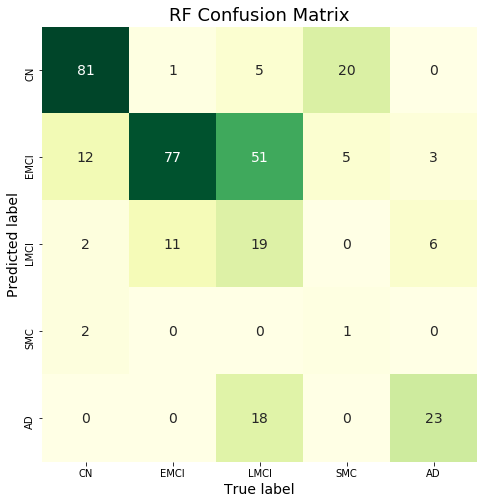

In [2212]:
# Constructing the confusion matrix
rf_mat = confusion_matrix(y_test, y_pred)
# Defining heigh & width for the figure
plt.figure(figsize=(8,8))
# Defining parameters for the heat map
ax = sns.heatmap(rf_mat1.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlGn', annot_kws={"size": 14})
ax.set_ylim(5,0)
# Defining title and label names
plt.title('RF Confusion Matrix', fontsize=18)
plt.xlabel('True label', fontsize=14)
plt.ylabel('Predicted label', fontsize=14)
# Denoting ticks on the axis
ax.set_xticklabels(labels=['CN','EMCI','LMCI','SMC','AD'])
ax.set_yticklabels(labels=['CN','EMCI','LMCI','SMC','AD'])
# Showing the plot
plt.show()

In [2213]:
# Evaluating accuracy
rf_model.score(X_test,y_test)

0.6053412462908012

In [2214]:
# Classification report - computing precision, recall, f1-score
# print(classification_report(y_test, y_pred, target_names=['CN','EMCI','AD'], labels=[1,2,5]))
print(classification_report(y_test, y_pred, target_names=['CN','EMCI','LMCI','SMC','AD']))

              precision    recall  f1-score   support

          CN       0.75      0.85      0.80        97
        EMCI       0.52      0.83      0.64        89
        LMCI       0.52      0.26      0.35        93
         SMC       0.00      0.00      0.00        26
          AD       0.60      0.75      0.67        32

    accuracy                           0.61       337
   macro avg       0.48      0.54      0.49       337
weighted avg       0.56      0.61      0.56       337



In [2215]:
balanced_accuracy_score(y_test,y_pred)

0.5369772030057207

# Evaluating Neural Network Model

In [2194]:
y_nn_test = y_test.reshape((-1,1))-1
y_nn_train = y_train.reshape((-1,1))-1
X_nn_train = X_train.to_numpy()
X_nn_test = X_test.to_numpy()
np.set_printoptions(suppress=True)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train-1), y_train-1)

In [2195]:
%%time
# Creating the model
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=14,  activation='relu', kernel_constraint=max_norm(1)))
nn_model.add(Dropout(0.1))
#nn_model.add(Dense(42, activation='relu'))
nn_model.add(Dense(5, activation='softmax'))
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.summary()


Model: "sequential_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_510 (Dense)            (None, 12)                180       
_________________________________________________________________
dropout_128 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_511 (Dense)            (None, 5)                 65        
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
Wall time: 57.9 ms


In [2196]:
%%time
# Training the model
nn_model.fit(x=X_nn_train, y=y_nn_train, batch_size=128, epochs=100, class_weight=class_weights, validation_split=0.2)


Train on 627 samples, validate on 157 samples
Epoch 1/100
627/627 [==============================] - 0s 523us/step - loss: 534591.8771 - accuracy: 0.1898 - val_loss: 467535.3328 - val_accuracy: 0.2420
Epoch 2/100
627/627 [==============================] - 0s 17us/step - loss: 510692.8818 - accuracy: 0.1914 - val_loss: 438985.0939 - val_accuracy: 0.2420
Epoch 3/100
627/627 [==============================] - 0s 19us/step - loss: 469075.4244 - accuracy: 0.1850 - val_loss: 410937.5941 - val_accuracy: 0.2420
Epoch 4/100
627/627 [==============================] - 0s 19us/step - loss: 451310.2284 - accuracy: 0.1866 - val_loss: 384025.6517 - val_accuracy: 0.2420
Epoch 5/100
627/627 [==============================] - 0s 19us/step - loss: 419730.0839 - accuracy: 0.1786 - val_loss: 358737.5854 - val_accuracy: 0.2420
Epoch 6/100
627/627 [==============================] - 0s 19us/step - loss: 394325.4744 - accuracy: 0.1898 - val_loss: 334391.3927 - val_accuracy: 0.2420
Epoch 7/100
627/627 [========

Epoch 54/100
627/627 [==============================] - 0s 13us/step - loss: 43622.9100 - accuracy: 0.1962 - val_loss: 8522.6790 - val_accuracy: 0.3185
Epoch 55/100
627/627 [==============================] - 0s 17us/step - loss: 39228.0428 - accuracy: 0.2360 - val_loss: 7053.3609 - val_accuracy: 0.2102
Epoch 56/100
627/627 [==============================] - 0s 13us/step - loss: 36272.8426 - accuracy: 0.2392 - val_loss: 5499.0838 - val_accuracy: 0.3248
Epoch 57/100
627/627 [==============================] - 0s 18us/step - loss: 34470.4004 - accuracy: 0.2344 - val_loss: 4221.1907 - val_accuracy: 0.1847
Epoch 58/100
627/627 [==============================] - 0s 16us/step - loss: 34975.1310 - accuracy: 0.2360 - val_loss: 2656.3848 - val_accuracy: 0.3057
Epoch 59/100
627/627 [==============================] - 0s 13us/step - loss: 31545.3941 - accuracy: 0.2297 - val_loss: 1285.2154 - val_accuracy: 0.2803
Epoch 60/100
627/627 [==============================] - 0s 16us/step - loss: 29999.7549 

In [2197]:
%%time
# Using model to predict target labels
y_pred = nn_model.predict_classes(X_nn_test, verbose=2)+1

Wall time: 61.8 ms


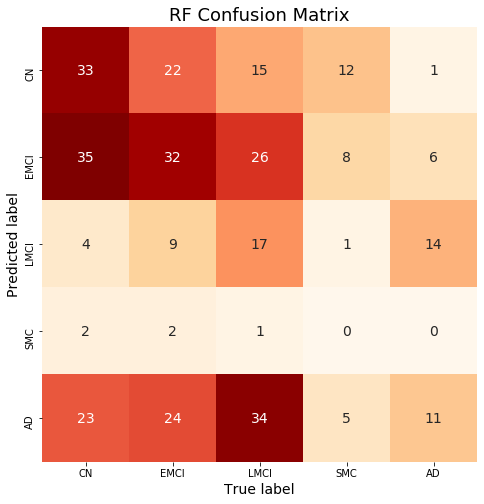

In [2198]:
# Constructing the confusion matrix
nn_mat = confusion_matrix(y_test, y_pred)
# Defining heigh & width for the figure
plt.figure(figsize=(8,8))
# Defining parameters for the heat map
ax = sns.heatmap(nn_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='OrRd', annot_kws={"size": 14})
ax.set_ylim(5,0)
# Defining title and label names
plt.title('RF Confusion Matrix', fontsize=18)
plt.xlabel('True label', fontsize=14)
plt.ylabel('Predicted label', fontsize=14)
# Denoting ticks on the axis
ax.set_xticklabels(labels=['CN','EMCI','LMCI','SMC','AD'])
ax.set_yticklabels(labels=['CN','EMCI','LMCI','SMC','AD'])
# Showing the plot
plt.show()

In [2199]:
# Evaluating accuracy
_, accuracy = nn_model.evaluate(X_nn_test, y_nn_test, verbose=0)
print(accuracy)

0.2759643793106079


In [2200]:
# Classification report - computing precision, recall, f1-score
# print(classification_report(y_test, y_pred, target_names=['CN','EMCI','AD'], labels=[1,2,5]))
print(classification_report(y_test, y_pred, target_names=['CN','EMCI','LMCI','SMC','AD']))

              precision    recall  f1-score   support

          CN       0.40      0.34      0.37        97
        EMCI       0.30      0.36      0.33        89
        LMCI       0.38      0.18      0.25        93
         SMC       0.00      0.00      0.00        26
          AD       0.11      0.34      0.17        32

    accuracy                           0.28       337
   macro avg       0.24      0.25      0.22       337
weighted avg       0.31      0.28      0.28       337



In [2201]:
balanced_accuracy_score(y_test,y_pred)

0.24526048925789884